# Face Anti-Spoofing Detection
Transfer learning of a MobileNetV2 is used as the classifier, in order to provide fast inference time with respectable precision

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

color = sns.color_palette()
%matplotlib inline

# Set seed nunmber to all packages
seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)


Configuring directories

# balanced 

In [3]:
import os
import shutil
import random

In [4]:
source_path = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training'
destination_path = '/kaggle/working/LCC_FASD_training'

In [5]:
real_destination = os.path.join(destination_path, 'real')
spoof_destination = os.path.join(destination_path, 'spoof')

os.makedirs(real_destination, exist_ok=True)
os.makedirs(spoof_destination, exist_ok=True)

In [6]:
real_images = os.listdir(os.path.join(source_path, 'real'))
spoof_images = os.listdir(os.path.join(source_path, 'spoof'))

In [7]:
sampled_spoof_images = random.sample(spoof_images, 1500)

In [8]:
# Copy real images
for image in real_images:
    shutil.copy(os.path.join(source_path, 'real', image), os.path.join(real_destination, image))

# Copy sampled spoof images
for image in sampled_spoof_images:
    shutil.copy(os.path.join(source_path, 'spoof', image), os.path.join(spoof_destination, image))

In [10]:

# Define paths for 'real' and 'spoof' directories
real_dir = os.path.join(base_dir, 'real')
spoof_dir = os.path.join(base_dir, 'spoof')

# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Count files in 'real' and 'spoof' directories
num_real_images = count_files(real_dir)
num_spoof_images = count_files(spoof_dir)

print(f"Number of 'real' images: {num_real_images}")
print(f"Number of 'spoof' images: {num_spoof_images}")

Number of 'real' images: 1223
Number of 'spoof' images: 1500


# adding extra real photos

In [11]:
celeba_spoof_path = '/kaggle/input/celeba-spoof-dataset/photo'
# Function to copy files from a directory to the destination directory
def copy_images(source_dir, dest_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):  # Adjust the extensions as needed
                shutil.copy(os.path.join(root, file), os.path.join(dest_dir, file))

# Copy images from celeba-spoof dataset
copy_images(celeba_spoof_path, real_destination)

In [15]:
# Define paths for 'real' and 'spoof' directories
real_dir = os.path.join(base_dir, 'real')
spoof_dir = os.path.join(base_dir, 'spoof')

# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Count files in 'real' and 'spoof' directories
num_real_images = count_files(real_dir)
num_spoof_images = count_files(spoof_dir)

print(f"Number of 'real' images: {num_real_images}")
print(f"Number of 'spoof' images: {num_spoof_images}")

Number of 'real' images: 1242
Number of 'spoof' images: 1500


In [16]:
anti_spoofing_live_path = '/kaggle/input/anti-spoofing-live/samples'
temp_path = '/kaggle/working/copie'
os.makedirs(temp_path, exist_ok=True)

In [17]:
# Function to copy images from a source directory to a destination directory
def copy_images1(source_dir, dest_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.startswith('live_selfie') and file.lower().endswith(('jpg', 'jpeg', 'png')):
                source_file = os.path.join(root, file)
                # Append directory name as a unique identifier to the filename
                unique_name = os.path.basename(os.path.dirname(source_file)) + '_' + file
                destination_file = os.path.join(dest_dir, unique_name)
                shutil.copy(source_file, destination_file)
                print(f"Copied: {source_file} to {destination_file}")

# Copy live selfies from the anti-spoofing live dataset to temporary directory
copy_images1(anti_spoofing_live_path, temp_path)

Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--624324023caf6971024bd220/live_selfie.jpg to /kaggle/working/copie/0001e96803--624324023caf6971024bd220_live_selfie.jpg
Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--6266a9012065600057a7394e/live_selfie.jpg to /kaggle/working/copie/0001e96803--6266a9012065600057a7394e_live_selfie.jpg
Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--621f74f67610eb59dffc6431/live_selfie.jpg to /kaggle/working/copie/0001e96803--621f74f67610eb59dffc6431_live_selfie.jpg
Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--623a074bb0675269bc1442ae/live_selfie.jpg to /kaggle/working/copie/0001e96803--623a074bb0675269bc1442ae_live_selfie.jpg
Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--62294efac72a824e5bb369f3/live_selfie.jpg to /kaggle/working/copie/0001e96803--62294efac72a824e5bb369f3_live_selfie.jpg
Copied: /kaggle/input/anti-spoofing-live/samples/0001e96803--621ea6c1b99da7739f2be705/live_selfie.jp

In [18]:
# Copy images from celeba-spoof dataset
copy_images(temp_path, real_destination)

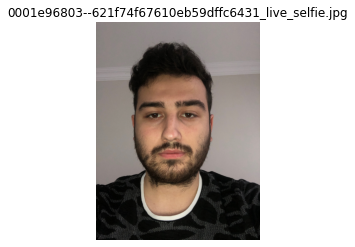

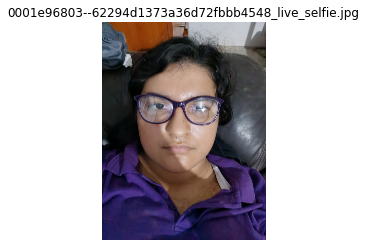

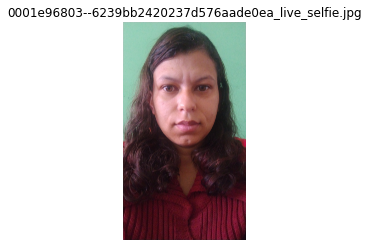

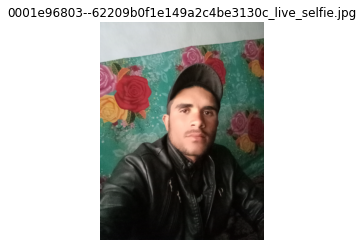

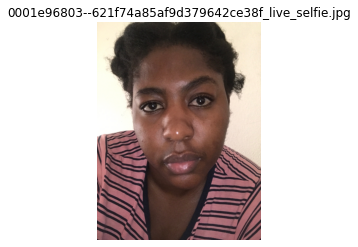

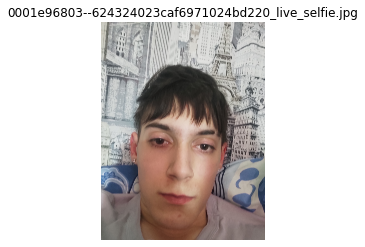

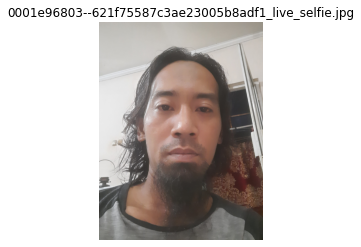

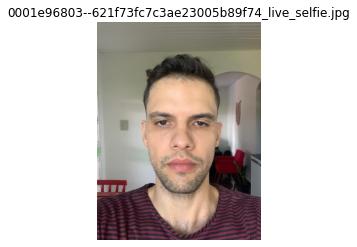

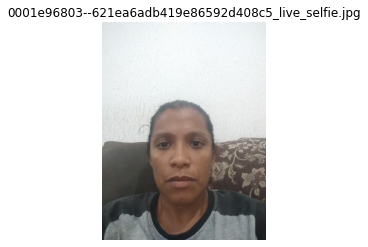

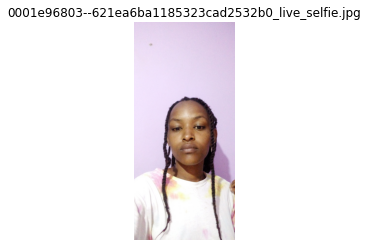

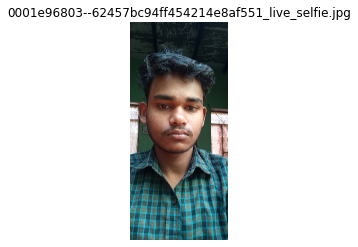

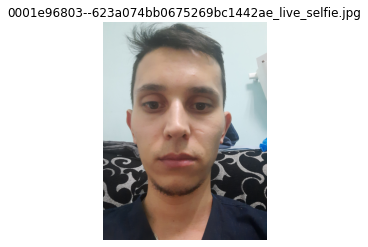

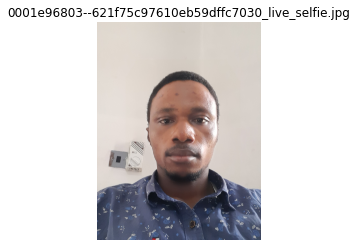

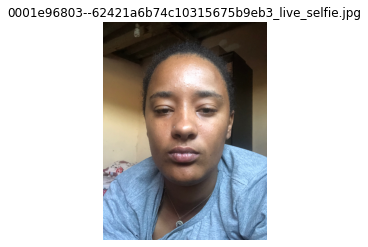

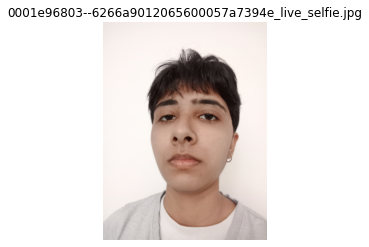

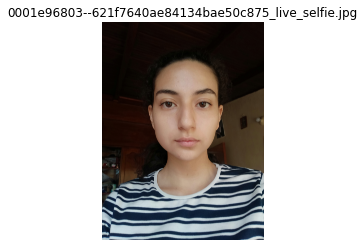

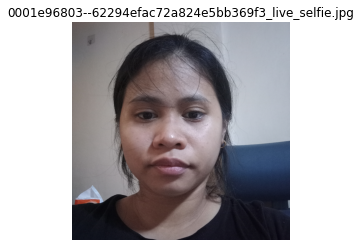

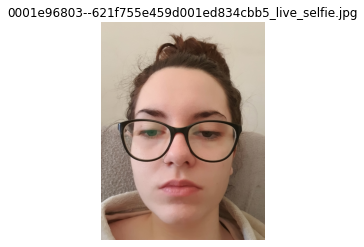

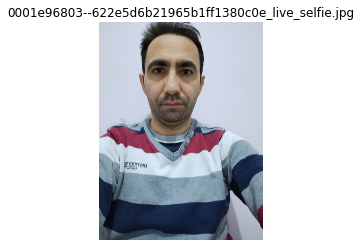

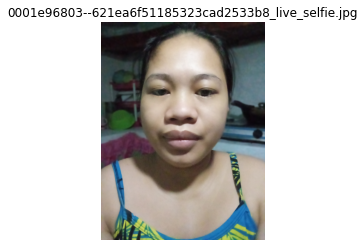

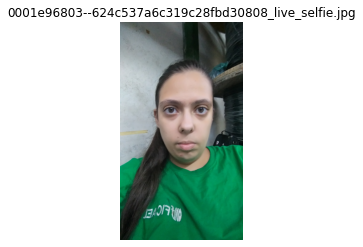

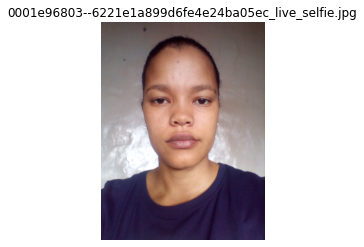

TypeError: Image data of dtype object cannot be converted to float

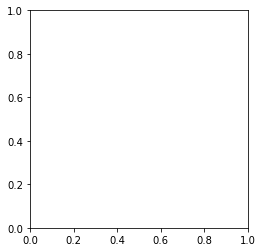

In [22]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

temp_path = '/kaggle/working/copie'

# List all files in the temporary directory
files = os.listdir(temp_path)

# Display each image
for file in files:
    if file.lower().endswith(('jpg', 'jpeg', 'png')):
        img_path = os.path.join(temp_path, file)
        img = mpimg.imread(img_path)
        plt.figure()
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
        plt.show()

In [23]:
new_real_images = os.listdir(real_destination)
new_spoof_images = os.listdir(spoof_destination)

print(f"Number of real images: {len(new_real_images)}")
print(f"Number of spoof images: {len(new_spoof_images)}")

Number of real images: 1272
Number of spoof images: 1500


In [24]:
# Configuring directories

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
root = "../input/lcc-fasd"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = '/kaggle/working/LCC_FASD_training'
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

# Printing the directory informations
print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['LCC_FASD']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


# Observing the Dataset
Grasping some of the dataset information

In [25]:
train_dir

'/kaggle/working/LCC_FASD_training'

In [31]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        # Get list of files with .png, .jpg, and .jpeg extensions
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.[pP][nN][gG]")))) + \
                     list(sorted(glob.glob(os.path.join(val, label, "*.[jJ][pP][gG]")))) + \
                     list(sorted(glob.glob(os.path.join(val, label, "*.[jJ][pP][eE][gG]"))))

        if len(label_list) == 0:
            continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1272   405   314
spoof   1500  2543  7266


In [29]:
import os

# Define the directory path
real_directory = '/kaggle/working/LCC_FASD_training/real'

# Function to count files in a directory
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Count files in the 'real' directory
num_real_images = count_files(real_directory)

print(f"Number of images in 'real' directory: {num_real_images}")


Number of images in 'real' directory: 1272


# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [32]:
# Instantiate data generator for training procedure
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [33]:
# Define dataset properties
train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224

# Generate dataset for train, val and test
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
    test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
    test_gen = None

Found 2772 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [34]:
# Displaying the dataset generator information
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


# Generate Model
Using a pre-trained MobileNet-v2 model, provided by tensorflow

In [35]:
# Define dataset properties
train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224

In [36]:
# Don't forget to turn on the Internet to download the respective pre-trained weights!
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')

# load_param_path = '../input/mobilenet_v2/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Offline alternative
# pretrain_net.load_weights(load_param_path)  # Manually load the weights from the input directory

# ------ Freezing layer(s) up to a specific layer ------
freeze_before = None  #"block_16_expand"  # use None to train, use "all" to freeze all the layers

if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False


9412608/9406464 [==============================] - 1s 0us/step


In [37]:
import os
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Add custom layers with regularization
x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization added here
x = Dropout(rate=0.2, name='extra_dropout1')(x)  # Dropout added here
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization added here
x = Dropout(rate=0.2, name='extra_dropout2')(x)  # Dropout added here
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
print(model.summary())

Model: "mobilenetv2_spoof"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

# Perform Training
Define the training procedure

In [38]:
train_id = "lcc-train04b-weight_all"  # ID of the training procedure
num_epochs = 15  # Set the number of epochs to train
learning_rate = 5e-5  # Set the learning rate to use

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# Define model callback
save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

cont_filepath = "mobilenetv2-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "mobilenetv2-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

# Instantiate tensorboard
log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

# Instantiate learning rate scheduler with Plateau method
plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)

# Displaying tensorboard
#%tensorboard --logdir log_dir

# Define class weight
train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")

Training config of 'lcc-train04b-weight_all'...
Number of epoch	: 15
Initial LR	: 5e-05
Class weight	: {0: 1.0896226415094339, 1: 0.924}


In [39]:
# Printing some information about the train_gen
print(f"Found {train_gen.samples} images belonging to {train_gen.num_classes} classes.")
print(f"Class indices: {train_gen.class_indices}")
print(f"Batch size: {train_gen.batch_size}")

Found 2772 images belonging to 2 classes.
Class indices: {'real': 0, 'spoof': 1}
Batch size: 32


In [40]:
# Perform training
history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [best_checkpoint,
                                 cont_checkpoint,
                                 plateau_scheduler],
                    class_weight=class_weight)

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

Epoch 1/15
86/86 [==============================] - 85s 986ms/step - loss: 1.4700 - acc: 0.7810 - val_loss: 1.5344 - val_acc: 0.6875 - lr: 5.0000e-05
Epoch 2/15
86/86 [==============================] - 86s 994ms/step - loss: 1.1610 - acc: 0.9347 - val_loss: 2.3547 - val_acc: 0.5312 - lr: 5.0000e-05
Epoch 3/15
86/86 [==============================] - 86s 1s/step - loss: 1.0459 - acc: 0.9672 - val_loss: 2.1049 - val_acc: 0.5938 - lr: 5.0000e-05
Epoch 4/15
86/86 [==============================] - ETA: 0s - loss: 0.9739 - acc: 0.9755
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
86/86 [==============================] - 85s 991ms/step - loss: 0.9739 - acc: 0.9755 - val_loss: 2.6070 - val_acc: 0.3750 - lr: 5.0000e-05
Epoch 5/15
86/86 [==============================] - 85s 993ms/step - loss: 0.9309 - acc: 0.9821 - val_loss: 2.5668 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 6/15
86/86 [==============================] - 86s 1s/step - loss: 0.9097 - acc: 0.9861 - 

Start training!

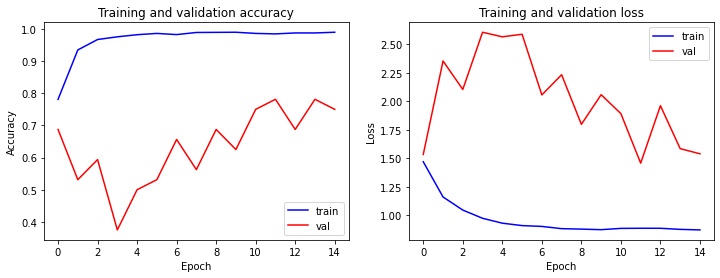

In [41]:
# Plotting the train results
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation
Use this section to evaluate the model performance on the Test set.

In [42]:
# Test set accuracy and loss
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

# Calculate prediction
threshold = 0.5  # Define the sigmoid threshold for True or False
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

7580/7580 [==============================] - 174s 23ms/step - loss: 1.3789 - acc: 0.8232
Test results Accuracy: 82.32% and Loss: 82.32
7580/7580 [==============================] - 111s 15ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 0 0 0 0 0 0 0 0]


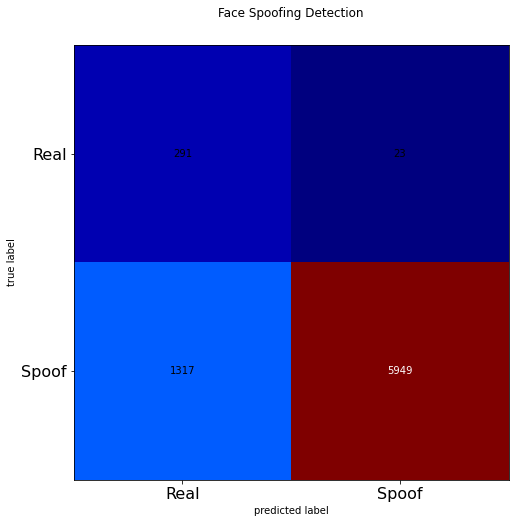

Report Summary:
Precision	: 99.61%
Recall		: 81.87%
F1 Score	: 89.88%

Notes: 
True labels	: Spoof
False labels	: Real


In [43]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")

# Load the model+test

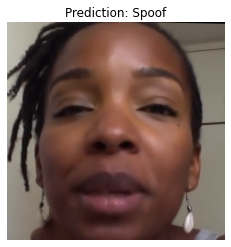

In [44]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = load_model('/kaggle/working/lcc-train04b-weight_all/mobilenetv2-epoch_15.hdf5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Path to the image you want to test
img_path = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/real/real_110.png'

# Preprocess the image
img = preprocess_image(img_path, target_size=(224, 224))

# Predict the class of the image
prediction = model.predict(img)

# Assuming the model output is a single probability
if prediction[0] > 0.5:
    result = "Real"
else:
    result = "Spoof"

# Load the image again for display
original_img = image.load_img(img_path)

# Display the image
plt.imshow(original_img)
plt.title(f"Prediction: {result}")
plt.axis('off')
plt.show()


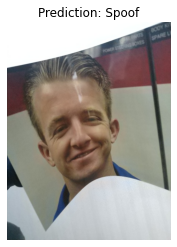

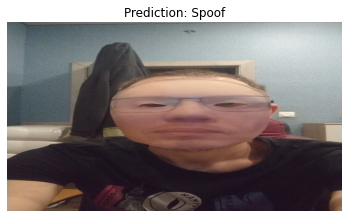

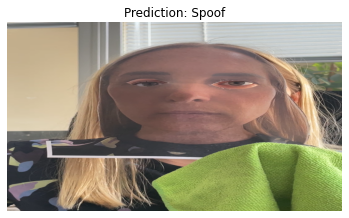

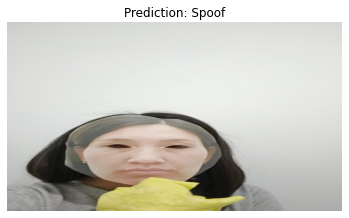

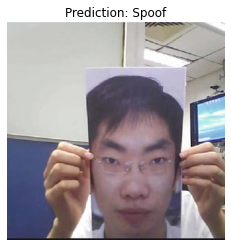

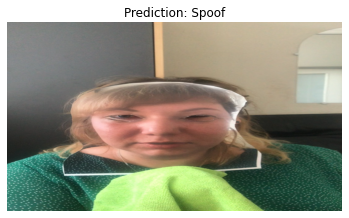

In [45]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os


# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Directory containing the images
img_dir = '/kaggle/input/testtts/face/spoof'

# Iterate through all images in the directory
for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    
    # Preprocess the image
    img = preprocess_image(img_path, target_size=(224, 224))
    
    # Predict the class of the image
    prediction = model.predict(img)
    
    # Determine the result
    if prediction[0] > 0.5:
        result = "Real"
    else:
        result = "Spoof"
    
    # Load the image again for display
    original_img = image.load_img(img_path)
    
    # Display the image
    plt.imshow(original_img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()


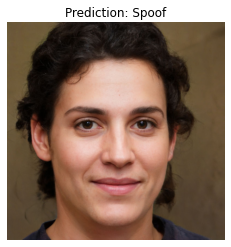

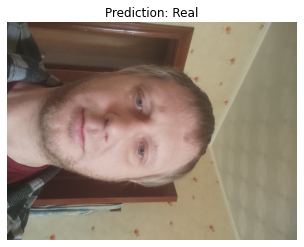

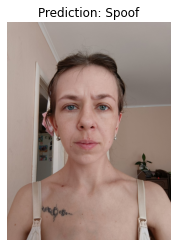

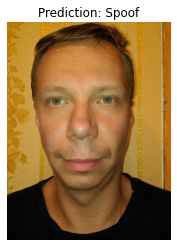

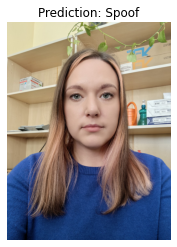

In [46]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os


# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Directory containing the images
img_dir = '/kaggle/input/testtts/face/real'

# Iterate through all images in the directory
for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    
    # Preprocess the image
    img = preprocess_image(img_path, target_size=(224, 224))
    
    # Predict the class of the image
    prediction = model.predict(img)
    
    # Determine the result
    if prediction[0] > 0.5:
        result = "Real"
    else:
        result = "Spoof"
    
    # Load the image again for display
    original_img = image.load_img(img_path)
    
    # Display the image
    plt.imshow(original_img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()


In [47]:
model

In [48]:
model.save("face-latest.hdf5")